In [55]:
#import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)

import category_encoders as ce

#Libraries requried for classification
from sklearn.model_selection import cross_val_score 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as metrics
from sklearn.preprocessing import RobustScaler
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
#read the data
bank_df = pd.read_csv('bank-full.csv')

In [3]:
#check the loading of the data
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
#Get the information on number of records , features, non-null count , data type
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
Target       45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


There are 45211 records. Good number of records for training and testing.

16 independent columns and one target column.

There are no null records indicating no missing entries.

Although there are many 'unknown' values which we will deal later.

***Continous variables*** - age , balance , day , duration , campaign ,pdays, previous

***Categorical variables*** - job, marital,education, default ,balance,housing,loan,contact,month,poutcome

***Target variable*** - Target

day is infact categorical , but we will keep it as numerical as it will help in model training.

In [5]:
bank_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


***Observations***

***Age*** : 
- Age data starts at 18 indicating the accounts are held by adults.
- The 75th percentile is at 48 indicating the majority of the customers are in working age group.
- The max goes upto 95 .Happy to see senior citizens holding account in the bank. but we need to analyze these records to see their validity. 
- Definitely, the data is positively skewed with outliers on the right end.
- With the high number of records ,we dont expect standard deviation as high as 10.

***balance : Annual average balance of the customer***

- Interesting to see customers holding a negative balance upto 8019 Euros.
- The 50th percentile is at 448 while the mean is at 1362 indicating high skewness in the data.
- The 75th percentile is only at 1428 but max goes upto 102127 Euros.

***day : day of the month when the contact was done***

- day is uniformly distributed indicating the customers are contacted every day of the month.

***duration : duration of the call with customers***

- the min value is 0 , it might be the value for customers who were not contacted.
- the standard deviation and the mean is nearly equal , it will be interesting to visualize this distribution.
- the max value goes upto 4918 - nearly 82 hours!! 
- as per the details given in the describtion of the data, the duration is highly correlated with the target.

***campaign : number of calls made during the campaign*** 
- the number of call stays 3 upto 75 percentile.
- the max goes upto 63.

***pdays : number of days before previously contacted***

- most of the value is -1 .No information is given about the negative value in the data describtion.
- for non-contacted customer ,as per the data describtion , the value is 999 .But the max value is 871 indicating no such customer.
- There is definitely some errors with this data.

***previous : number of contacts made before this campaign***
 upto 75 th percentile , the value is zero indicating mostly the customers were not contacted before this campaign.
 But there are some customers with the value of 275 .
 
 
 
<font color=blue size=3>**"all the features are highly skewed.there might be multiple clusters in the data .visualzing the distribution is very important"**</font>


# Univariate Analysis

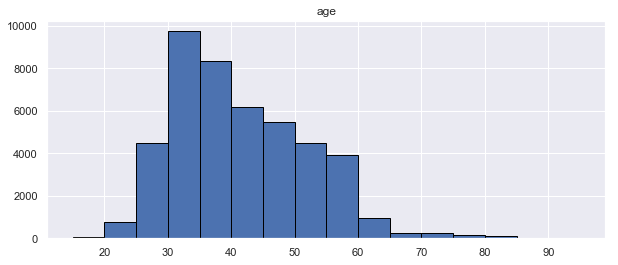

In [6]:
#check the distribution of age of customers
bank_df.hist(column = ['age'], edgecolor = 'black',bins =np.arange(15,100,5) , figsize=(10,4))
plt.show()

Most of the customers are in the age range of 20 to 60 .
we are not sure about the retirement age of Portugal but looks like the most of the customers hold the account in the age range of 20 to 60.we can check that later during bivariate analysis with job column

Let us visit the records of the customers with more than 90 years of age.

In [7]:
bank_df[bank_df['age']>90]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
31233,94,retired,divorced,secondary,no,1234,no,no,cellular,3,mar,212,1,-1,0,unknown,no
33699,95,retired,divorced,primary,no,2282,no,no,telephone,21,apr,207,17,-1,0,unknown,yes
41663,95,retired,married,secondary,no,0,no,no,telephone,1,oct,215,1,-1,0,unknown,no
41934,92,retired,married,unknown,no,775,no,no,cellular,22,oct,313,3,-1,0,unknown,yes
42727,92,retired,married,unknown,no,775,no,no,cellular,26,jan,164,4,96,3,success,yes
44262,93,retired,married,unknown,no,775,no,no,cellular,22,jul,860,2,177,7,success,yes
44420,93,retired,married,unknown,no,775,no,no,cellular,4,aug,476,2,13,9,success,yes


Of the people above age 90 , five out of seven customers opted for the term deposit.

Though the number of calls made for this campaign (campaign column) is less , the duration minutes are significantly high.

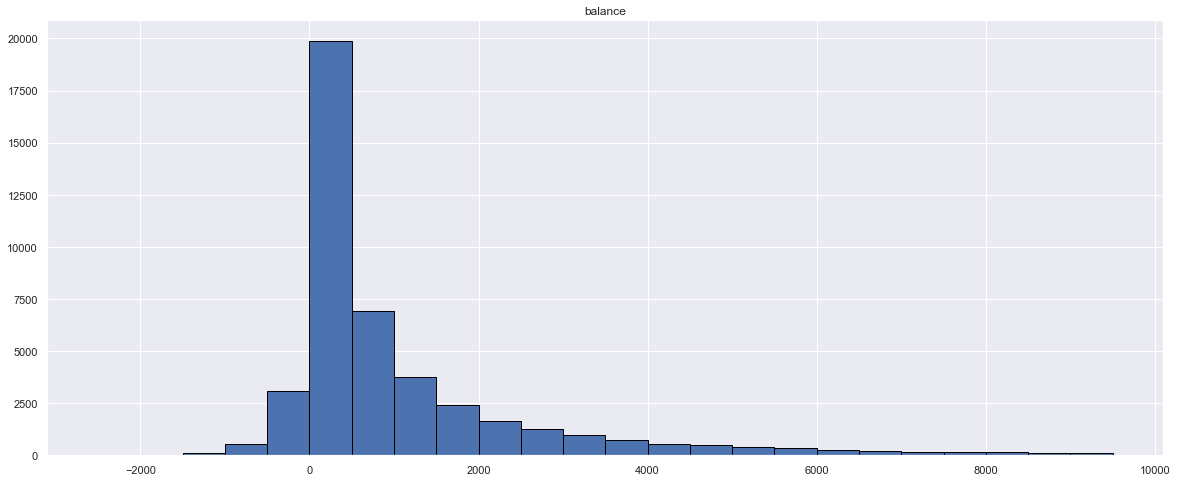

In [8]:
bank_df.hist(column = ['balance'], edgecolor = 'black',bins =np.arange(-2500,10000,500) , figsize=(20,8))
#sns.distplot(bank_df['balance'])
plt.show()

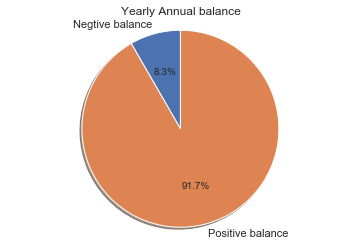

In [9]:
labels = 'Negtive balance', 'Positive balance'
neg_balance = bank_df[bank_df['balance'] < 0].count()
pos_balance = bank_df[bank_df['balance'] >= 0].count()
sizes = [neg_balance[0], pos_balance[0]]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Yearly Annual balance")
plt.show()



In [10]:
bank_df[bank_df['balance'] > 50000].count()

age          18
job          18
marital      18
education    18
default      18
balance      18
housing      18
loan         18
contact      18
day          18
month        18
duration     18
campaign     18
pdays        18
previous     18
poutcome     18
Target       18
dtype: int64

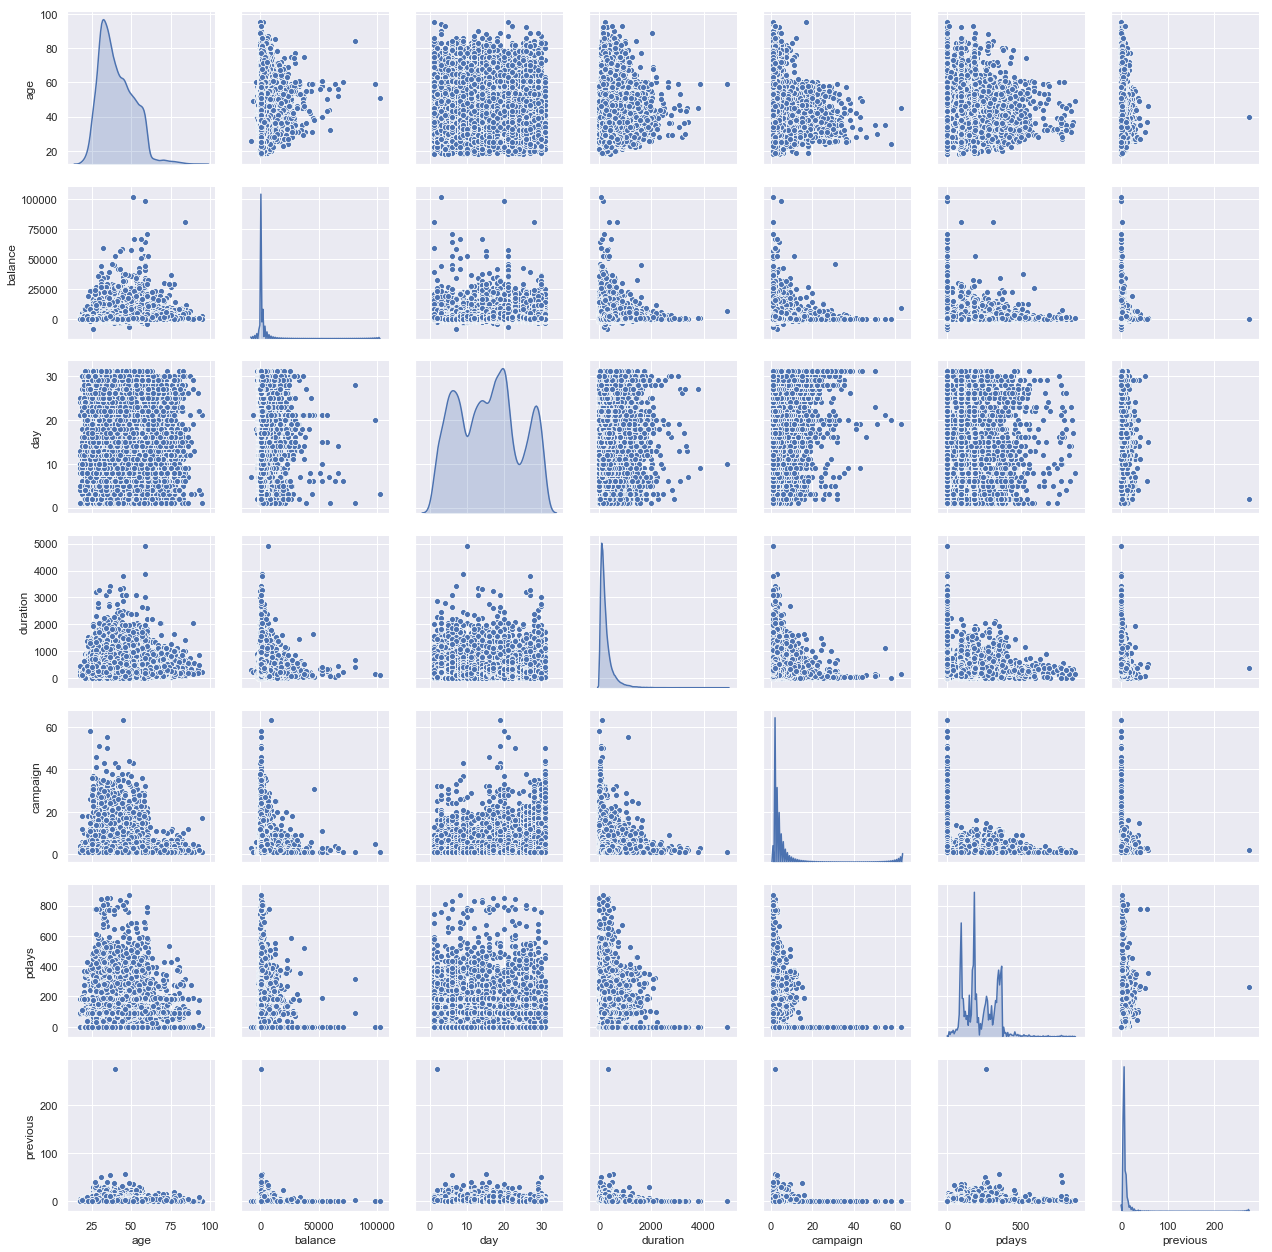

In [11]:
sns.pairplot(bank_df , diag_kind='kde') # perfoming pairplot to check all the distributions and outliers

# Feature Engineering - Encoding categorical variables

In [12]:
#One-hot-coding of categorical variables : the categorical variables must be in the value of 0 or 1 .
#Otherwise the algorithms will consider them as weighted values instead of categories
#job, marital,education, default ,balance,housing,loan,contact,month,poutcome
categories_to_swap = ['marital','education','default','housing','loan','contact','poutcome'] 
#pandas get dummies function does one hot coding 
temp_df = pd.get_dummies(bank_df[categories_to_swap], prefix=categories_to_swap) 
temp_df.head()
bank_df.drop(categories_to_swap, axis=1, inplace=True)
bank_df = pd.concat([bank_df, temp_df], axis=1)
bank_df.head()

,age,job,balance,day,month,duration,campaign,pdays,previous,Target,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,management,2143,5,may,261,1,-1,0,no,...,1,1,0,0,0,1,0,0,0,1
1,44,technician,29,5,may,151,1,-1,0,no,...,1,1,0,0,0,1,0,0,0,1
2,33,entrepreneur,2,5,may,76,1,-1,0,no,...,1,0,1,0,0,1,0,0,0,1
3,47,blue-collar,1506,5,may,92,1,-1,0,no,...,1,1,0,0,0,1,0,0,0,1
4,33,unknown,1,5,may,198,1,-1,0,no,...,0,1,0,0,0,1,0,0,0,1


In [13]:
#since there are many values in the job column , we go for binary encoding instead of one-hot
encoder = ce.BinaryEncoder(cols=['job']) # call the category encoder
df_binary = encoder.fit_transform(bank_df)
df_binary.head()

,age,job_0,job_1,job_2,job_3,job_4,balance,day,month,duration,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,0,0,0,1,2143,5,may,261,...,1,1,0,0,0,1,0,0,0,1
1,44,0,0,0,1,0,29,5,may,151,...,1,1,0,0,0,1,0,0,0,1
2,33,0,0,0,1,1,2,5,may,76,...,1,0,1,0,0,1,0,0,0,1
3,47,0,0,1,0,0,1506,5,may,92,...,1,1,0,0,0,1,0,0,0,1
4,33,0,0,1,0,1,1,5,may,198,...,0,1,0,0,0,1,0,0,0,1


In [14]:
bank_df['month'].value_counts()

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

In [15]:
# for month , custom Label encoding is done because there is a relation to maintain chronological order
month_map = {'month': {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
                                  'may': 5, 'jun': 6, 'jul': 7 , 'aug': 8 , 'sep': 9,'oct': 10,'nov': 11,'dec':12}}
bank_df.replace(month_map, inplace=True)
bank_df.head()

,age,job,balance,day,month,duration,campaign,pdays,previous,Target,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,management,2143,5,5,261,1,-1,0,no,...,1,1,0,0,0,1,0,0,0,1
1,44,technician,29,5,5,151,1,-1,0,no,...,1,1,0,0,0,1,0,0,0,1
2,33,entrepreneur,2,5,5,76,1,-1,0,no,...,1,0,1,0,0,1,0,0,0,1
3,47,blue-collar,1506,5,5,92,1,-1,0,no,...,1,1,0,0,0,1,0,0,0,1
4,33,unknown,1,5,5,198,1,-1,0,no,...,0,1,0,0,0,1,0,0,0,1


In [16]:
#Target column is encoded with 0 and 1
bank_df['Target'].value_counts()
target_map = {'Target': {'no': 0, 'yes': 1,}}
bank_df.replace(target_map, inplace=True)
bank_df.head()

,age,job,balance,day,month,duration,campaign,pdays,previous,Target,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,management,2143,5,5,261,1,-1,0,0,...,1,1,0,0,0,1,0,0,0,1
1,44,technician,29,5,5,151,1,-1,0,0,...,1,1,0,0,0,1,0,0,0,1
2,33,entrepreneur,2,5,5,76,1,-1,0,0,...,1,0,1,0,0,1,0,0,0,1
3,47,blue-collar,1506,5,5,92,1,-1,0,0,...,1,1,0,0,0,1,0,0,0,1
4,33,unknown,1,5,5,198,1,-1,0,0,...,0,1,0,0,0,1,0,0,0,1


In [36]:
bank_df['Target'].value_counts()

0    39922
1     5289
Name: Target, dtype: int64

In [17]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 30 columns):
age                    45211 non-null int64
job                    45211 non-null object
balance                45211 non-null int64
day                    45211 non-null int64
month                  45211 non-null int64
duration               45211 non-null int64
campaign               45211 non-null int64
pdays                  45211 non-null int64
previous               45211 non-null int64
Target                 45211 non-null int64
marital_divorced       45211 non-null uint8
marital_married        45211 non-null uint8
marital_single         45211 non-null uint8
education_primary      45211 non-null uint8
education_secondary    45211 non-null uint8
education_tertiary     45211 non-null uint8
education_unknown      45211 non-null uint8
default_no             45211 non-null uint8
default_yes            45211 non-null uint8
housing_no             45211 non-null uint8
housing_ye

In [18]:
categories_swap = ['job','month']
bank_df.drop(categories_swap, axis=1, inplace=True)
bank_df.head()

,age,balance,day,duration,campaign,pdays,previous,Target,marital_divorced,marital_married,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0,1,...,1,1,0,0,0,1,0,0,0,1
1,44,29,5,151,1,-1,0,0,0,0,...,1,1,0,0,0,1,0,0,0,1
2,33,2,5,76,1,-1,0,0,0,1,...,1,0,1,0,0,1,0,0,0,1
3,47,1506,5,92,1,-1,0,0,0,1,...,1,1,0,0,0,1,0,0,0,1
4,33,1,5,198,1,-1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1


In [19]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 28 columns):
age                    45211 non-null int64
balance                45211 non-null int64
day                    45211 non-null int64
duration               45211 non-null int64
campaign               45211 non-null int64
pdays                  45211 non-null int64
previous               45211 non-null int64
Target                 45211 non-null int64
marital_divorced       45211 non-null uint8
marital_married        45211 non-null uint8
marital_single         45211 non-null uint8
education_primary      45211 non-null uint8
education_secondary    45211 non-null uint8
education_tertiary     45211 non-null uint8
education_unknown      45211 non-null uint8
default_no             45211 non-null uint8
default_yes            45211 non-null uint8
housing_no             45211 non-null uint8
housing_yes            45211 non-null uint8
loan_no                45211 non-null uint8
loan_yes   

# Supervised Learning 

In [20]:
def cross_validation_scores(model , X_train, y_train):
    """Gives the cross validation Accurancy mean and standard deviation"""
    
    accuracies_lr= cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10) 
    accuracies_lr_mean=accuracies_lr.mean()*100
    print("Mean Accuracy for cross validation = ",accuracies_lr_mean)

    accuracies_lr_std=accuracies_lr.std()*100
    print("Standard Deviation for cross validation = ",accuracies_lr_std)

In [21]:
def get_auc_roc_score(model, X_train, y_train) :
    """Gives the Auc Roc Scores from cross validation"""
    
    mean_roc_auc_score = cross_val_score(estimator = model, X = X_train, y = y_train, scoring="roc_auc", cv = 7).mean()
    std_roc_auc_score = cross_val_score(estimator = model, X = X_train, y = y_train, scoring="roc_auc", cv = 7).std()

    print("Mean AUC ROC Score:",mean_roc_auc_score)
    print("Std Dev AUC ROC Score:",std_roc_auc_score)


In [22]:
def train_classifier(classifier, X_train, X_test, y_train, y_test):
    """Trains the classifier algorithm , cross validates and prints the results"""
    
    classifier.fit(X_train,y_train) # train model
    y_pred=classifier.predict(X_test) # test model
    test_score = classifier.score(X_test, y_test) # get testing score
    train_score = classifier.score(X_train,y_train) # get training score
    print("training score = " ,train_score)
    print("testing score = " ,test_score)
    
    cross_validation_scores(classifier , X_train, y_train) # get cross validation scores
    get_auc_roc_score(classifier , X_train, y_train) # get auc_roc scores

In [23]:
#List of classifiers algorithms to try
classifiers = [
    LogisticRegression(solver='liblinear'),
    KNeighborsClassifier(n_neighbors=3)
    ]
#SVC(kernel="rbf", C=0.025, probability=True, gamma = 0.025)
#commented SVC as it was taking long time to run

In [24]:
#utility method to iterate over all the algorithms
def train_and_print_training_scores(classifiers,X_train, X_test, y_train, y_test):
"""Trains the array of classifier algorithm , cross validates and prints the results"""
    for classifier in classifiers: #iterate through all classifiers
        name = classifier.__class__.__name__ # get the classifier name
    
        print("="*30)
        print(name)
    
        print('****Results****')
        
        train_classifier(classifier, X_train, X_test, y_train, y_test) # train the model
        

In [25]:
def print_classification_report_loan_class(classifiers,X_train, X_test, y_train, y_test):
    """Trains the array of classifier algorithm , prints the classification results"""
    # Logging for Visual Comparison
    log_cols=["Classifier", "FN", "TP" , "Precision" , "Recall" , "F1_score"]
    log = pd.DataFrame(columns=log_cols)
    
    for classifier in classifiers: #iterate through all classifiers
        name = classifier.__class__.__name__ # get the classifier name
        classifier.fit(X_train,y_train) # train model
        y_pred=classifier.predict(X_test) # test model
        
        label_for_loan = [1]
        
        confusion_mat = confusion_matrix(y_test,y_pred) #get the confusion matrix
        precision = metrics.precision_score(y_test, y_pred, average='weighted', labels=label_for_loan)
        recall = metrics.recall_score(y_test, y_pred, average='weighted', labels=label_for_loan)
        f1_score = metrics.f1_score(y_test, y_pred, average='weighted', labels=label_for_loan)


        False_Negative  = confusion_mat[1,0]
        True_Positive = confusion_mat[1,1]
        
        log_entry = pd.DataFrame([[name, False_Negative, True_Positive ,precision ,recall ,f1_score ]], columns=log_cols)
        log = log.append(log_entry)
   
    
    print(log.sort_values(by=['F1_score'], ascending=False))

In [26]:
X = bank_df.drop('Target', axis=1) 
y = bank_df['Target']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Trial 1 : Traditional Classifiers

In [28]:
#train the given set of classifiers and print the results
train_and_print_training_scores(classifiers , X_train, X_test, y_train, y_test)

LogisticRegression
****Results****
training score =  0.9005908932916232
testing score =  0.9007667354762607
Mean Accuracy for cross validation =  90.06857339042892
Standard Deviation for cross validation =  0.19762307308398655
Mean AUC ROC Score: 0.8889646433842034
Std Dev AUC ROC Score: 0.006101136548103481
KNeighborsClassifier
****Results****
training score =  0.9234998578064272
testing score =  0.8765850781480389
Mean Accuracy for cross validation =  87.54388106863009
Standard Deviation for cross validation =  0.3655753337908749
Mean AUC ROC Score: 0.7234396284983446
Std Dev AUC ROC Score: 0.005729311621933865


***Observations***:

- The traditional classifiers have given a very good testing score near to 90 percent.
- Even the mean accuracy of the cross validation remains high.
- AUC - Roc  score also has a good value.

In [30]:
print_classification_report_loan_class(classifiers,X_train, X_test, y_train, y_test)

             Classifier    FN   TP  Precision    Recall  F1_score
0    LogisticRegression  1045  506   0.627014  0.326241  0.429177
0  KNeighborsClassifier  1099  452   0.440117  0.291425  0.350659


***Observations:***

- the precision values are not upto the mark.

Let us try ensembling techniques to improve the precision

# Trail 2 : Ensemble techniques

In [31]:
ensemble_classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators = 10),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]

In [32]:
#train the given set of classifiers and print the results
train_and_print_training_scores(ensemble_classifiers , X_train, X_test, y_train, y_test)

DecisionTreeClassifier
****Results****
training score =  1.0
testing score =  0.865526393394279
Mean Accuracy for cross validation =  86.17881332984301
Standard Deviation for cross validation =  0.8943220025489647
Mean AUC ROC Score: 0.6847570615737101
Std Dev AUC ROC Score: 0.012810519508264725
RandomForestClassifier
****Results****
training score =  0.9903308370461655
testing score =  0.8964169861397818
Mean Accuracy for cross validation =  89.6420281137203
Standard Deviation for cross validation =  0.3414314249136853
Mean AUC ROC Score: 0.8624290984221996
Std Dev AUC ROC Score: 0.0075690901499908736
AdaBoostClassifier
****Results****
training score =  0.9000537175719657
testing score =  0.90002948982601
Mean Accuracy for cross validation =  89.90109785786615
Standard Deviation for cross validation =  0.3931297616362369
Mean AUC ROC Score: 0.9003792824271176
Std Dev AUC ROC Score: 0.005878631588360991
GradientBoostingClassifier
****Results****
training score =  0.9077321705058932
tes

In [35]:
print_classification_report_loan_class(ensemble_classifiers,X_train, X_test, y_train, y_test)

                   Classifier    FN   TP  Precision    Recall  F1_score
0  GradientBoostingClassifier   942  609   0.622063  0.392650  0.481423
0          AdaBoostClassifier  1000  551   0.607497  0.355255  0.448332
0      DecisionTreeClassifier   845  706   0.410227  0.455190  0.431540
0      RandomForestClassifier  1040  511   0.580682  0.329465  0.420403


With Ensembling techniques , we donot see much improvement in the precision or accuracy.

# Trial 3 : Ensemble techniques with Upsampling

In [43]:
bank_df_upsampled = bank_df.copy()
df_majority=bank_df[bank_df_upsampled['Target']==0] ## all rows where Not.fully.paid==0
df_minority=bank_df[bank_df_upsampled['Target']==1] ## all rows where Not.fully.paid==1

df_minority_upsampled=resample(df_minority,replace=True,n_samples=8045)
df_upsampled=pd.concat([df_minority_upsampled,df_minority])

bank_df_upsampled = bank_df_upsampled.append(df_upsampled)
bank_df_upsampled['Target'].value_counts()

0    39922
1    18623
Name: Target, dtype: int64

In [51]:
X_upsampled = bank_df_upsampled.drop('Target', axis=1) 
y_upsampled = bank_df_upsampled['Target']
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(X_upsampled, y_upsampled, test_size=0.30, random_state=1)

In [52]:
ensemble_classifiers1 = [
    RandomForestClassifier(n_estimators = 10),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]

In [54]:
train_and_print_training_scores(ensemble_classifiers,X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled)

DecisionTreeClassifier
****Results****
training score =  1.0
testing score =  0.9224550216351628
Mean Accuracy for cross validation =  91.46187395562194
Standard Deviation for cross validation =  0.22518384480579132
Mean AUC ROC Score: 0.9183461469319584
Std Dev AUC ROC Score: 0.003693939240336112
RandomForestClassifier
****Results****
training score =  0.99736463239062
testing score =  0.9423821452971988
Mean Accuracy for cross validation =  93.58480134648039
Standard Deviation for cross validation =  0.3726069901108833
Mean AUC ROC Score: 0.9764986860851893
Std Dev AUC ROC Score: 0.002664870468691567
AdaBoostClassifier
****Results****
training score =  0.8335082111222274
testing score =  0.8302778410384878
Mean Accuracy for cross validation =  83.10680570646475
Standard Deviation for cross validation =  0.2474048844602272
Mean AUC ROC Score: 0.9021978970164495
Std Dev AUC ROC Score: 0.0024974710336930746
GradientBoostingClassifier
****Results****
training score =  0.8463190258900466


In [64]:
print_classification_report_loan_class(ensemble_classifiers,X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled)

                   Classifier    FN    TP  Precision    Recall  F1_score
0      RandomForestClassifier   316  5192   0.878660  0.942629  0.909521
0      DecisionTreeClassifier   220  5288   0.823548  0.960058  0.886579
0  GradientBoostingClassifier  1512  3996   0.761868  0.725490  0.743234
0          AdaBoostClassifier  1857  3651   0.764607  0.662854  0.710104


<font color=green size=5>With Upsamling and ensemble techniques , the accuracy, precision ,especially F1 score improved significantly (from 0.48 to 0.90 ) <font>

# Trail 4 : Hyper-tuned Ensemble technique with Upsampled data

In [56]:
classifier = RandomForestClassifier(n_estimators=25)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)] ## play with start and stop

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 5)] ## change 10,20 and 2
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,15]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,10]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [20, 65, 110, 155, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 12, 15, 17, 20, None], 'min_samples_split': [2, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 10], 'bootstrap': [True, False]}


In [58]:
rf_random = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid, n_iter = 100, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1)

In [60]:
hyper_tuned_classifier = [rf_random]

In [61]:
train_and_print_training_scores(hyper_tuned_classifier,X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled)

RandomizedSearchCV
****Results****
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.3min finished


training score =  1.0
testing score =  0.9462537007515373
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.7min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.0min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.3min


KeyboardInterrupt: 

interupted the randomized search cross validation as it needed high computing power which my PC could not provide.

In [ ]:
However , we could see the testing accuracy has increased from 94.23 to 94.65.

In [62]:
print_classification_report_loan_class(hyper_tuned_classifier,X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.5min finished


           Classifier   FN    TP  Precision    Recall  F1_score
0  RandomizedSearchCV  199  5309   0.873766  0.963871  0.916609


In [63]:
print("Best Parameters are:",rf_random.best_params_)

Best Parameters are: {'n_estimators': 65, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


# Conclusion

The data given is highly skewed.The data had class-imbalance problem for the target variable.

With our trails , Hyper-tuned random forest classifier with upsampling of the data has given us higher accuracy.

Final testing accuracy :94.65

Precision : 0.8737

F1_score : 0.9166

Things to do further : we can stacking and blending techniques to see improvements.